In [1]:
from functools import partial
import numpy as np
import os
import pandas as pd
import scipy

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


import sys
sys.path.append('../')
import util

save_fig = partial(util.save_fig, save=True)

**Default parameters - will be replaced**

In [2]:
### IGNORE THIS CELL, IT WILL BE OVERWRITTEN
dataset_file = '/home/drake/workspace/em-2020/data/combined_dataset_all_final.csv'
index_fields = ['Country', 'Year']
data_fields = ['ENI' ,'POP', 'URB', 'AFL' , 'TI', 'CTS' ,'KAOPEN']
prefix = 'template'
start_year = 2005
end_year = 2015
exclude_countries = []
pickle_file = '/home/drake/workspace/em-2020/analysis/D3_gmm/template_output.pickle.bz2'
pdynmc_params = {
    "use.mc.diff": True,
    "use.mc.lev": False,
    "use.mc.nonlin": True,
    "include.y": True,
    "varname.y": "ENI",
    "lagTerms.y": 2,
    "fur.con": True,
    "fur.con.diff": True,
    "fur.con.lev": False,
    "varname.reg.fur": ["POP", "AFL", "AFL2", "URB", "CTS", "TI", "KAOPEN"],
    "lagTerms.reg.fur": [0, 0, 0, 0, 0, 0, 0],
    "include.dum": True,
    "dum.diff": True,
    "dum.lev": False,
    "w.mat": "iid.err",
    "std.err": "corrected",
    "estimation": "iterative",
    "opt.meth": "BFGS",
    "inst.stata": False,
}
plm_formula = 'ENI ~ lag(ENI, 1:2) + POP + AFL + AFL2 + URB + CTS + TI + KAOPEN | lag(ENI, 2:99)'
plm_params = {
    'effect': 'twoways',
    'model': 'twostep',
    'collapse': False,
    'transformation': 'd',
}

**End of parameter section** 

In [3]:
%get dataset_file index_fields data_fields start_year end_year exclude_countries 
%get pdynmc_params plm_formula plm_params

# SoS mangles dict keys, for no apparent reason
names(pdynmc_params) <- gsub('_', '.', names(pdynmc_params))
names(plm_params) <- gsub('_', '.', names(plm_params))

suppressMessages({
library(dplyr)
library(plm)
library(pdynmc)
})
`%notin%` <- Negate(`%in%`)

data.df <- subset(
    read.csv(dataset_file), select=c(index_fields, data_fields),
    subset=(Country %notin% exclude_countries) 
    & (start_year <= Year) & (Year <= end_year)
)
data.df['AFL2'] = data.df['AFL']^2
data.panel <- pdata.frame(data.df, index = c("Country", "Year"), drop.index = TRUE, row.names=TRUE)

head(data.df %>% 
    group_by(Country) %>% 
    summarize(min=min(Year), max=max(Year), .groups='drop'))

Country,min,max
<fct>,<int>,<int>
ALB,2005,2011
ARG,2005,2014
ARM,2005,2014
AUS,2005,2015
AUT,2005,2015
AZE,2005,2014


In [4]:
pdynmc_params

$use.mc.diff
[1] TRUE

$use.mc.lev
[1] FALSE

$use.mc.nonlin
[1] TRUE

$include.y
[1] TRUE

$varname.y
[1] "ENI"

$lagTerms.y
[1] 2

$fur.con
[1] TRUE

$fur.con.diff
[1] TRUE

$fur.con.lev
[1] FALSE

$varname.reg.fur
[1] "POP"    "AFL"    "AFL2"   "URB"    "CTS"    "TI"     "KAOPEN"

$lagTerms.reg.fur
[1] 0 0 0 0 0 0 0

$include.dum
[1] TRUE

$dum.diff
[1] TRUE

$dum.lev
[1] FALSE

$w.mat
[1] "iid.err"

$std.err
[1] "corrected"

$estimation
[1] "iterative"

$opt.meth
[1] "BFGS"

$inst.stata
[1] FALSE

In [5]:
pdynmc_base_params <- list(dat = data.df, 
                    varname.i = "Country", varname.t = "Year", varname.dum = "Year")

pdynmc_fit <- do.call(pdynmc, modifyList(pdynmc_base_params, pdynmc_params))
pdynmc_summary <- summary(pdynmc_fit)
pdynmc_summary

fn is  fn 
Looking for method =  BFGS 
Function has  17  arguments
Analytic gradient not made available.
Analytic Hessian not made available.
Scale check -- log parameter ratio= 1.398692   log bounds ratio= NA 
Method:  BFGS 
initial  value 10187705.723864 
iter  10 value 9336.597159
iter  20 value 8465.342288
iter  30 value 98.767954
iter  40 value 13.288142
iter  50 value 13.198668
final  value 13.073068 
converged
Post processing for method  BFGS 
Successful convergence! 
Save results from method  BFGS 
$par
 [1]  0.3523073410  0.0548291938  0.0404989653 -0.1543675921 -0.0239796093
 [6]  0.6216913567  0.0319704163 -0.0019780841  0.0020683759  0.0081789654
[11] -0.0015625881  0.0127295518 -0.0009242523  0.0061352662 -0.0130353550
[16] -0.0066172015  0.0019927094

$value
[1] 13.07307

$message
NULL

$convcode
[1] 0

$fevals
function 
     261 

$gevals
gradient 
      56 

$nitns
[1] NA

$kkt1
[1] NA

$kkt2
[1] NA

$xtimes
user.self 
   86.427 

Assemble the answers
fn is  fn 
Looking

Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”


Scale check -- log parameter ratio= 4.035568   log bounds ratio= NA 
Method:  BFGS 
initial  value 69.976945 
iter  10 value 64.151900
iter  10 value 64.151900
iter  20 value 62.409354
final  value 62.409353 
converged
Post processing for method  BFGS 
Successful convergence! 
Save results from method  BFGS 
$par
 [1]  0.346886771  0.049394729  0.045444803 -0.138751640 -0.026031114
 [6]  0.628093034  0.003804802  0.002517125  0.008830723  0.005991032
[11] -0.006370827  0.005972980 -0.003165788  0.004956604 -0.011891456
[16] -0.001561027  0.003932867

$value
[1] 62.40935

$message
NULL

$convcode
[1] 0

$fevals
function 
     301 

$gevals
gradient 
      21 

$nitns
[1] NA

$kkt1
[1] NA

$kkt2
[1] NA

$xtimes
user.self 
   43.574 

Assemble the answers
fn is  fn 
Looking for method =  BFGS 
Function has  17  arguments
Analytic gradient not made available.
Analytic Hessian not made available.
Scale check -- log parameter ratio= 2.604614   log bounds ratio= NA 
Method:  BFGS 
initial  va

Warning message in optimx.check(par, optcfg$ufn, optcfg$ugr, optcfg$uhess, lower, :
“Parameters or bounds appear to have different scalings.
  This can cause poor performance in optimization. 
  It is important for derivative free methods like BOBYQA, UOBYQA, NEWUOA.”


Scale check -- log parameter ratio= 3.133431   log bounds ratio= NA 
Method:  BFGS 
initial  value 63.603136 
iter  10 value 61.051055
final  value 60.979009 
converged
Post processing for method  BFGS 
Successful convergence! 
Save results from method  BFGS 
$par
 [1]  0.343727361  0.046468310  0.048137118 -0.129419626 -0.027268951
 [6]  0.631480434 -0.008807148  0.007407884  0.012196402  0.004919703
[11] -0.007902406  0.003659029 -0.004295894  0.005965866 -0.010653588
[16]  0.002232414  0.005433164

$value
[1] 60.97901

$message
NULL

$convcode
[1] 0

$fevals
function 
     251 

$gevals
gradient 
      16 

$nitns
[1] NA

$kkt1
[1] NA

$kkt2
[1] NA

$xtimes
user.self 
   33.653 

Assemble the answers
fn is  fn 
Looking for method =  BFGS 
Function has  17  arguments
Analytic gradient not made available.
Analytic Hessian not made available.
Scale check -- log parameter ratio= 2.451585   log bounds ratio= NA 
Method:  BFGS 
initial  value 62.063773 
iter  10 value 60.763031
iter  20 v


Dynamic linear panel estimation (iterative)
Estimation steps: 10

Coefficients:
           Estimate Std.Err.rob z-value.rob Pr(>|z.rob|)    
L1.ENI     0.340409    0.099092       3.435      0.00059 ***
L2.ENI     0.042232    0.051347       0.822      0.41108    
L0.POP     0.051342    0.250135       0.205      0.83757    
L0.AFL    -0.120546    0.487811      -0.247      0.80491    
L0.AFL2   -0.028453    0.025912      -1.098      0.27220    
L0.URB     0.634701    0.389021       1.632      0.10268    
L0.CTS    -0.017351    0.019978      -0.868      0.38539    
L0.TI      0.013755    0.012032       1.143      0.25304    
L0.KAOPEN  0.016452    0.009308       1.768      0.07706 .  
2008       0.005328    0.007654       0.696      0.48643    
2009      -0.008743    0.014036      -0.623      0.53328    
2010       0.002991    0.017428       0.172      0.86344    
2011      -0.004844    0.020081      -0.241      0.80956    
2012       0.008200    0.024988       0.328      0.74291    
2013


Call:
lm(formula = residuals ~ fitted, data = pdynmc_resid)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.25220 -0.01301 -0.00066  0.01337  0.25924 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.007597   0.001646  -4.615 4.36e-06 ***
fitted      -0.225686   0.031545  -7.154 1.48e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04024 on 1168 degrees of freedom
  (165 observations deleted due to missingness)
Multiple R-squared:  0.04198,	Adjusted R-squared:  0.04116 
F-statistic: 51.19 on 1 and 1168 DF,  p-value: 1.479e-12


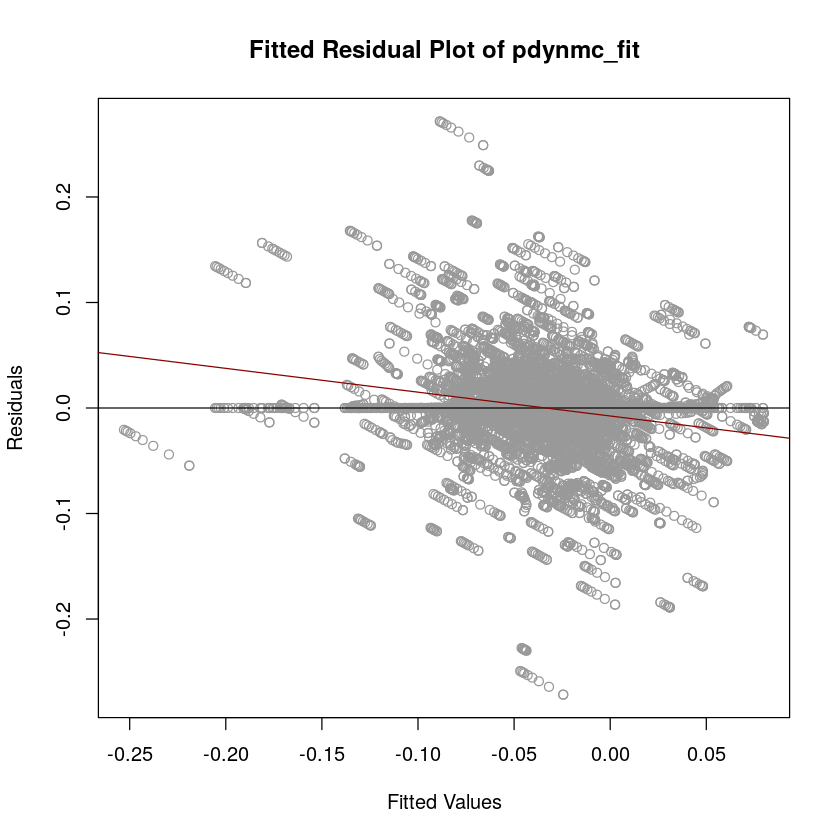

In [6]:
pdynmc_resid <- data.frame(residuals=unlist(residuals(pdynmc_fit)),
                           fitted=unlist(fitted.values(pdynmc_fit)))
resid.reg <- lm(residuals ~ fitted, data=pdynmc_resid)
plot(pdynmc_fit)
abline(resid.reg, col='darkred')
summary(resid.reg)

In [7]:
jtest.fct(pdynmc_fit)
ser.corr1 <- mtest.fct(pdynmc_fit, t.order = 1)
ser.corr1
ser.corr2 <- mtest.fct(pdynmc_fit, t.order = 2)
ser.corr2


	J-Test of Hansen

data:  10step GMM Estimation; H0: overidentifying restrictions valid
chisq = 60.213, df = 49, p-value = 0.1308



	Arrelano and Bond (1991) serial correlation test of degree 1

data:  10step GMM Estimation; H0: no serial correlation of order 1 in the error terms
normal = -5.4359, p-value = 5.451e-08



	Arrelano and Bond (1991) serial correlation test of degree 2

data:  10step GMM Estimation; H0: no serial correlation of order 2 in the error terms
normal = -1.4869, p-value = 0.137


In [8]:
pdynmc_tests <- do.call(rbind, lapply(
    list(pdynmc_summary$hansenj, pdynmc_summary$slopef, pdynmc_summary$time.dumf, ser.corr1, ser.corr2),
    function(x) {
        data.frame(stat=as.numeric(x$statistic), test=names(x$statistic),
                   p.value=x$p.value, row.names=x$method, result=x$data.name)
    }
))
pdynmc_tests

,stat,test,p.value,result
,<dbl>,<fct>,<dbl>,<fct>
J-Test of Hansen,60.212982,chisq,1.308328e-01,10step GMM Estimation; H0: overidentifying restrictions valid
Wald test,394.350946,chisq,2.197148e-79,10step GMM Estimation; H0: slope parameters are jointly zero
Wald test1,174.530945,chisq,1.447027e-33,10step GMM Estimation; H0: time.dum parameters are jointly zero
Arrelano and Bond (1991) serial correlation test of degree 1,-5.435935,normal,5.450990e-08,10step GMM Estimation; H0: no serial correlation of order 1 in the error terms
Arrelano and Bond (1991) serial correlation test of degree 2,-1.486931,normal,1.370330e-01,10step GMM Estimation; H0: no serial correlation of order 2 in the error terms


In [9]:
# plm.formula <- as.formula(plm_formula)
# plm.params = modifyList(list(plm.formula,
#                              data=data.panel),
#                         plm_params)
# z2 <- do.call(pgmm, plm.params)
# z2$call <- plm.formula
# summary(z2, robust = TRUE)

In [10]:
pdynmc_coef <- data.frame(pdynmc_summary$coefficients)

In [11]:
%get pdynmc_coef pdynmc_tests pdynmc_resid --from R
import pickle
import bz2

with bz2.BZ2File(pickle_file, 'w') as fd:
    pickle.dump({
        'pdynmc_coef': pdynmc_coef,
        'pdynmc_tests': pdynmc_tests,
        'pdynmc_resid': pdynmc_resid,
        'pdynmc_params': pdynmc_params,
        'start_year': start_year,
        'end_year': start_year,
        'varname.reg.fur': start_year,
        'start_year': start_year,
    }, fd)